### 分析一些finetune下游任务上的数据集特征

In [1]:
from dataclasses import dataclass
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
from PIL import Image
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Dict, Any, Tuple, Union, Optional
from transformers import AutoProcessor
from torch import Tensor
from dataclasses import dataclass

from show_llava.constants import IGNORE_INDEX, DEFAULT_IMAGE_TOKEN, MODEL_MAX_LENGTH

In [2]:
# 适用于单轮对话的finetune数据集
class finetune_SupervisedDataset(Dataset):
    """ Dataset for supervised fine-tuning in Llava stage2 train """
    
    def __init__(self, data_path: str, image_folder: str) -> None:
        super().__init__()
        self.data_path = data_path
        self.image_folder = Path(image_folder)
        self.chat_data = self.build_dataset(self.data_path)

    def build_dataset(self, data_path: str) -> List[Dict[str, Any]]:
        data_path = Path(data_path)
        chat_data = pd.read_json(path_or_buf=data_path).to_dict(orient="records")
        return chat_data
    
    def __len__(self) -> int:
        return len(self.chat_data)
    
    def __getitem__(self, index) -> tuple[str, str, Path]:
        cur_data = self.chat_data[index]
        human_input = cur_data['conversations'][0]['value']
        gpt_output = cur_data['conversations'][1]['value']
        image_path = None
        # TODO: 检查是否存在键值image，以及是否为None或Nan
        if 'image' in cur_data and cur_data['image'] is not None and not (isinstance(cur_data['image'], float) and math.isnan(cur_data['image'])):
            image_path = self.image_folder.joinpath(cur_data.get('image'))
        return (human_input, gpt_output, image_path)

@dataclass
class QaImageOutput:
    q_input_ids: torch.Tensor
    pixel_values: torch.Tensor
    a_input_ids: torch.Tensor

def preprocess_multimodal(q_text: str):
    if DEFAULT_IMAGE_TOKEN in q_text:
        q_text = q_text.replace(DEFAULT_IMAGE_TOKEN, '').strip()
        q_text = DEFAULT_IMAGE_TOKEN + '\n' + q_text
        q_text = q_text.strip()
    return q_text

def build_qaimage(processor: AutoProcessor, q_text: str, a_text: str, image_path: Path) -> QaImageOutput:
    is_multimodal = image_path is not None
    if is_multimodal: # adjust <image> position to the begin for instruction or input or question
        q_text = preprocess_multimodal(q_text)
    else:   # 非多模态数据添加默认的图片占位符，后续将mask掉
        q_text = DEFAULT_IMAGE_TOKEN + q_text
    
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": q_text},
    ]
    # 应用模板后将会应用speaker角色及start/end signal
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    
    # 生成Question部分的向量
    raw_image = None
    inputs = None
    if is_multimodal:  # 若原始数据中有图片, 则读取图片
        raw_image = Image.open(fp=image_path)
        inputs = processor(text=prompt, images=raw_image, return_tensors="pt")
    else:   # 若原始数据中没有图片, 生成一个占位图片，并在后续的处理中通过mask忽略掉占位图片
        crop_size = processor.image_processor.crop_size
        raw_image = torch.zeros(3, crop_size['height'], crop_size['width'])
        inputs = processor(text=prompt, images=raw_image, return_tensors="pt", do_rescale=False)
   
    # 生成Answer部分的向量
    # BEGIN_SIGNAL = '<|im_start|>'
    # END_SIGNAL = '<|im_end|>'
    # a_text = a_text + END_SIGNAL + '\n' + BEGIN_SIGNAL
    a_input_ids = processor.tokenizer(
        a_text,
        return_tensors="pt",
        padding="longest",
        truncation=True,
    )["input_ids"]
    return QaImageOutput(
        q_input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        a_input_ids=a_input_ids
    )

#### 统计在`ScienceQA`训练集上QCM+LEA格式的数据tokenizer后的token词数分布

In [3]:
train_data_path = "/d/lsy/shared_data/liuhaotian/LLaVA-Finetune/ScienceQA/llava_train_QCM-LEA.json"
image_folder = "/d/lsy/shared_data/liuhaotian/LLaVA-Finetune/ScienceQA/images/train"

train_sqadataset = finetune_SupervisedDataset(data_path=train_data_path, image_folder=image_folder)

llava_model_name_or_path = "./qwen2.5_3B_Instruct_clipvL14_model/model001"
processor = AutoProcessor.from_pretrained(pretrained_model_name_or_path=llava_model_name_or_path)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
train_len = len(train_sqadataset)
sqadataset_samplelen = []
train_qcm_len = []
train_lea_len = []
for i in range(train_len):
    qaimage_output = build_qaimage(processor=processor, q_text = train_sqadataset[i][0], a_text = train_sqadataset[i][1], image_path = train_sqadataset[i][2])
    sample_len = qaimage_output.q_input_ids.shape[1] + qaimage_output.a_input_ids.shape[1]
    train_qcm_len.append(qaimage_output.q_input_ids.shape[1])
    train_lea_len.append(qaimage_output.a_input_ids.shape[1])
    sqadataset_samplelen.append(sample_len)

In [18]:
for i in range(train_len):
    qaimage_output = build_qaimage(processor=processor, q_text = train_sqadataset[i][0], a_text = train_sqadataset[i][1], image_path = train_sqadataset[i][2])
    sample_len = qaimage_output.q_input_ids.shape[1] + qaimage_output.a_input_ids.shape[1]
    q_len = qaimage_output.q_input_ids.shape[1]
    a_len = qaimage_output.a_input_ids.shape[1]
    if q_len > 768 and a_len > 512:
        print(i, q_len, a_len, sample_len)
        break

887 808 559 1367


In [5]:
sqadataset_samplelen

[735,
 1132,
 1115,
 817,
 828,
 942,
 1255,
 828,
 1019,
 1093,
 880,
 847,
 799,
 818,
 1230,
 753,
 711,
 642,
 768,
 1415,
 764,
 1155,
 999,
 782,
 741,
 639,
 770,
 835,
 1044,
 809,
 918,
 633,
 1267,
 755,
 782,
 779,
 1086,
 1023,
 974,
 749,
 788,
 857,
 724,
 867,
 1034,
 1028,
 881,
 780,
 843,
 846,
 775,
 935,
 912,
 785,
 959,
 1420,
 809,
 878,
 782,
 752,
 1006,
 855,
 940,
 911,
 878,
 817,
 642,
 642,
 1063,
 930,
 894,
 821,
 837,
 922,
 740,
 1433,
 987,
 1173,
 883,
 822,
 770,
 1101,
 1008,
 839,
 734,
 833,
 862,
 781,
 742,
 665,
 798,
 1046,
 913,
 1133,
 830,
 782,
 751,
 638,
 816,
 666,
 823,
 1105,
 1045,
 878,
 817,
 847,
 794,
 960,
 829,
 720,
 946,
 738,
 818,
 757,
 981,
 1088,
 916,
 829,
 768,
 640,
 963,
 952,
 920,
 734,
 1244,
 773,
 943,
 839,
 640,
 783,
 735,
 642,
 790,
 732,
 905,
 852,
 828,
 636,
 907,
 779,
 807,
 726,
 783,
 732,
 1051,
 791,
 816,
 657,
 670,
 795,
 736,
 897,
 838,
 935,
 645,
 640,
 707,
 753,
 1160,
 843,
 642,
 821,

#### 绘制分布图

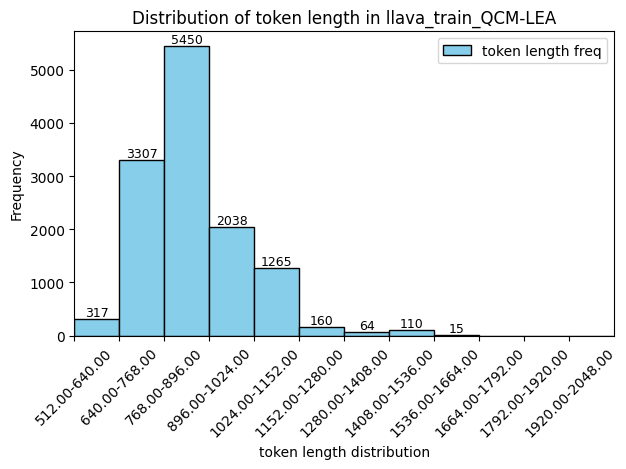

In [6]:
bin_start = 512
bin_end = 2048
bin_width = 128

bins = np.arange(bin_start, bin_end + bin_width, bin_width)
hist, bin_edges = np.histogram(sqadataset_samplelen, bins=bins)
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='skyblue')
plt.xlabel('token length distribution')
plt.ylabel('Frequency')
plt.title('Distribution of token length in llava_train_QCM-LEA')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['token length freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

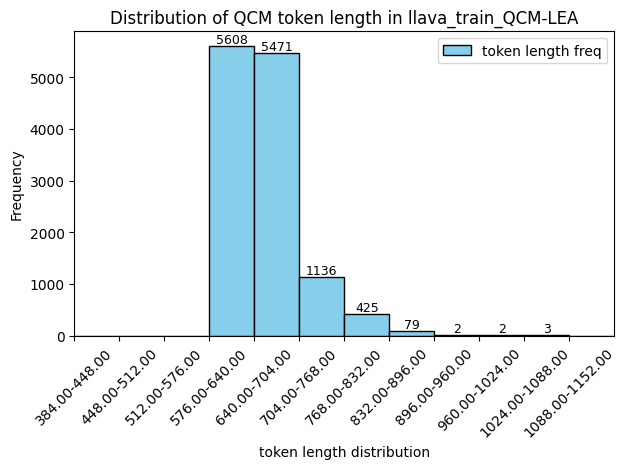

In [7]:
bin_start = 384
bin_end = 1152
bin_width = 64

bins = np.arange(bin_start, bin_end + bin_width, bin_width)
hist, bin_edges = np.histogram(train_qcm_len, bins=bins)
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='skyblue')
plt.xlabel('token length distribution')
plt.ylabel('Frequency')
plt.title('Distribution of QCM token length in llava_train_QCM-LEA')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['token length freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

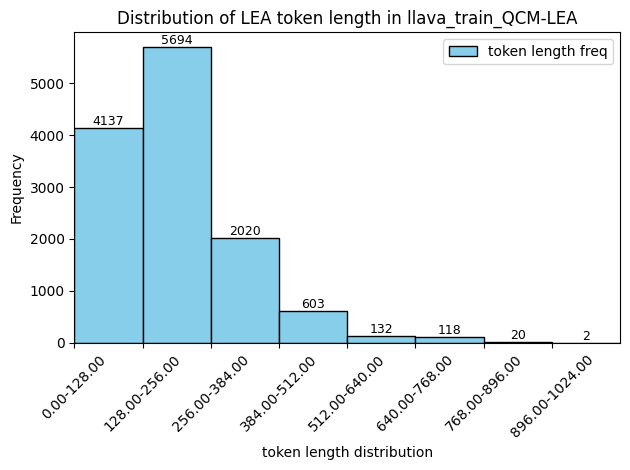

In [8]:
bin_start = 0
bin_end = 1024
bin_width = 128

bins = np.arange(bin_start, bin_end + bin_width, bin_width)
hist, bin_edges = np.histogram(train_lea_len, bins=bins)
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='skyblue')
plt.xlabel('token length distribution')
plt.ylabel('Frequency')
plt.title('Distribution of LEA token length in llava_train_QCM-LEA')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['token length freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

#### `test`and`val`数据集

In [9]:
test_data_path = "/d/lsy/shared_data/liuhaotian/LLaVA-Finetune/ScienceQA/llava_test_QCM-LEA.json"
val_data_path = "/d/lsy/shared_data/liuhaotian/LLaVA-Finetune/ScienceQA/llava_val_QCM-LEA.json"
test_image_folder = "/d/lsy/shared_data/liuhaotian/LLaVA-Finetune/ScienceQA/images/test"
val_image_folder = "/d/lsy/shared_data/liuhaotian/LLaVA-Finetune/ScienceQA/images/val"

In [10]:
test_sqadataset = finetune_SupervisedDataset(data_path=test_data_path, image_folder=test_image_folder)
val_sqadataset = finetune_SupervisedDataset(data_path=val_data_path, image_folder=val_image_folder)
test_len = len(test_sqadataset)
val_len = len(val_sqadataset)
test_sqa_samplelen = []
test_sqa_qcm_len = []
test_sqa_lea_len = []
val_sqa_samplelen = []
val_sqa_qcm_len = []
val_sqa_lea_len = []

for i in range(test_len):
    qaimage_output = build_qaimage(processor=processor, q_text = test_sqadataset[i][0], a_text = test_sqadataset[i][1], image_path = test_sqadataset[i][2])
    sample_len = qaimage_output.q_input_ids.shape[1] + qaimage_output.a_input_ids.shape[1]
    test_sqa_samplelen.append(sample_len)
    test_sqa_qcm_len.append(qaimage_output.q_input_ids.shape[1])
    test_sqa_lea_len.append(qaimage_output.a_input_ids.shape[1])

for i in range(val_len):
    qaimage_output = build_qaimage(processor=processor, q_text = val_sqadataset[i][0], a_text = val_sqadataset[i][1], image_path = val_sqadataset[i][2])
    sample_len = qaimage_output.q_input_ids.shape[1] + qaimage_output.a_input_ids.shape[1]
    val_sqa_samplelen.append(sample_len)
    val_sqa_qcm_len.append(qaimage_output.q_input_ids.shape[1])
    val_sqa_lea_len.append(qaimage_output.a_input_ids.shape[1])

In [11]:
test_sqa_samplelen, val_sqa_samplelen

([895,
  1119,
  671,
  783,
  781,
  942,
  849,
  1006,
  1081,
  1334,
  799,
  816,
  1047,
  907,
  643,
  717,
  1046,
  847,
  793,
  642,
  776,
  734,
  781,
  827,
  639,
  783,
  1053,
  782,
  769,
  657,
  783,
  772,
  802,
  784,
  1089,
  659,
  765,
  724,
  785,
  793,
  834,
  747,
  1070,
  642,
  975,
  698,
  829,
  766,
  839,
  865,
  1241,
  1137,
  770,
  726,
  992,
  1067,
  839,
  1103,
  891,
  643,
  757,
  824,
  742,
  670,
  918,
  789,
  845,
  881,
  780,
  987,
  647,
  813,
  907,
  1089,
  799,
  638,
  867,
  827,
  1016,
  645,
  816,
  943,
  772,
  745,
  876,
  848,
  1057,
  643,
  931,
  746,
  872,
  961,
  1090,
  1015,
  847,
  750,
  830,
  640,
  881,
  936,
  946,
  1000,
  969,
  831,
  880,
  789,
  742,
  773,
  645,
  735,
  879,
  851,
  749,
  840,
  895,
  822,
  933,
  714,
  1423,
  798,
  779,
  900,
  830,
  823,
  643,
  641,
  774,
  808,
  1153,
  643,
  1136,
  968,
  783,
  761,
  770,
  1008,
  924,
  643,
  643,
  79

#### 绘制分布图

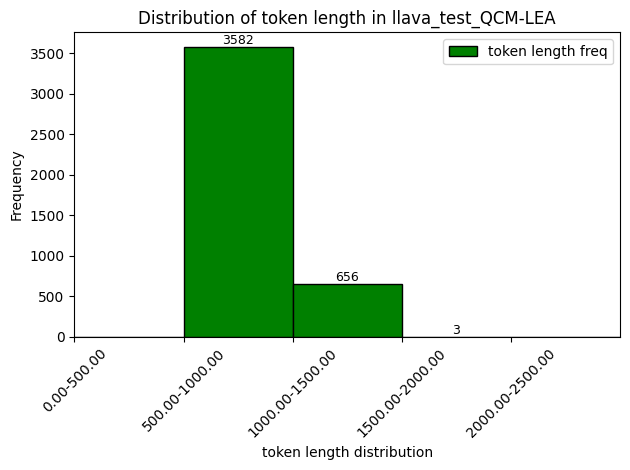

In [12]:
bin_start = 0
bin_end = 2500
bin_width = 500

bins = np.arange(bin_start, bin_end + bin_width, bin_width)
hist, bin_edges = np.histogram(test_sqa_samplelen, bins=bins)
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='green')
plt.xlabel('token length distribution')
plt.ylabel('Frequency')
plt.title('Distribution of token length in llava_test_QCM-LEA')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['token length freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

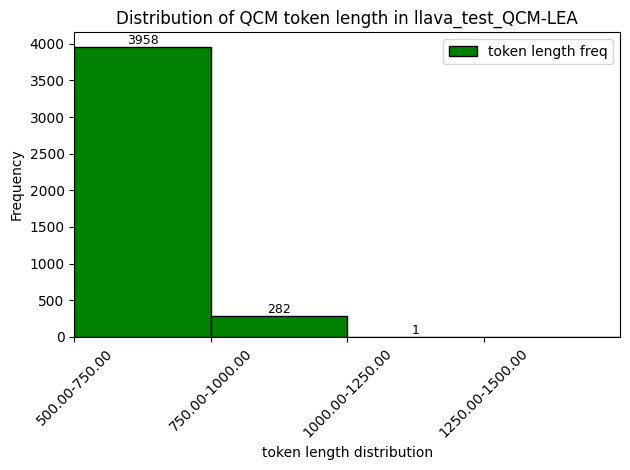

In [13]:
bin_start = 500
bin_end = 1500
bin_width = 250

bins = np.arange(bin_start, bin_end + bin_width, bin_width)
hist, bin_edges = np.histogram(test_sqa_qcm_len, bins=bins)
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='green')
plt.xlabel('token length distribution')
plt.ylabel('Frequency')
plt.title('Distribution of QCM token length in llava_test_QCM-LEA')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['token length freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

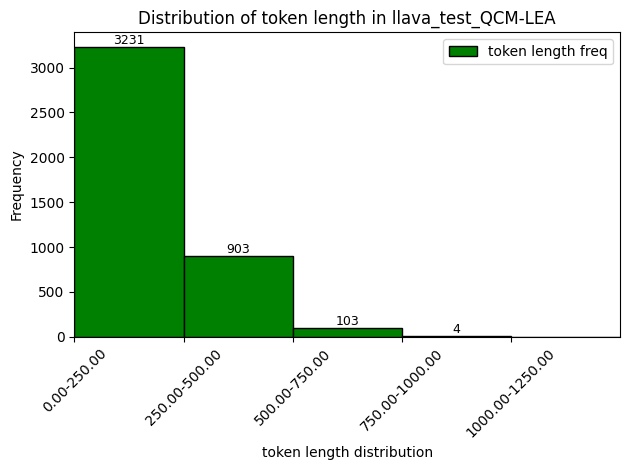

In [14]:
bin_start = 0
bin_end = 1250
bin_width = 250

bins = np.arange(bin_start, bin_end + bin_width, bin_width)
hist, bin_edges = np.histogram(test_sqa_lea_len, bins=bins)
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='green')
plt.xlabel('token length distribution')
plt.ylabel('Frequency')
plt.title('Distribution of token length in llava_test_QCM-LEA')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['token length freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

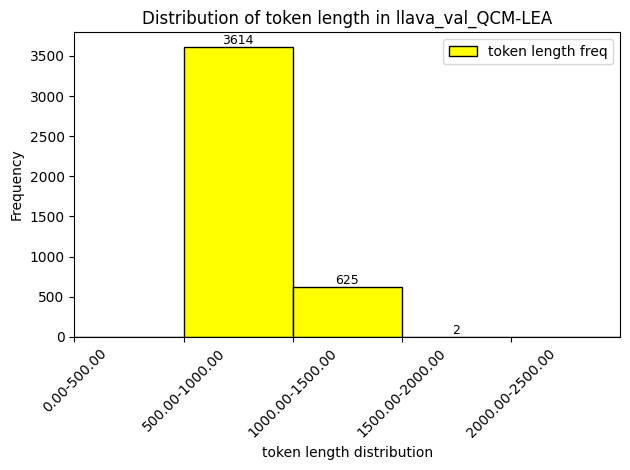

In [15]:
bin_start = 0
bin_end = 2500
bin_width = 500

bins = np.arange(bin_start, bin_end + bin_width, bin_width)
hist, bin_edges = np.histogram(val_sqa_samplelen, bins=bins)
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='yellow')
plt.xlabel('token length distribution')
plt.ylabel('Frequency')
plt.title('Distribution of token length in llava_val_QCM-LEA')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['token length freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

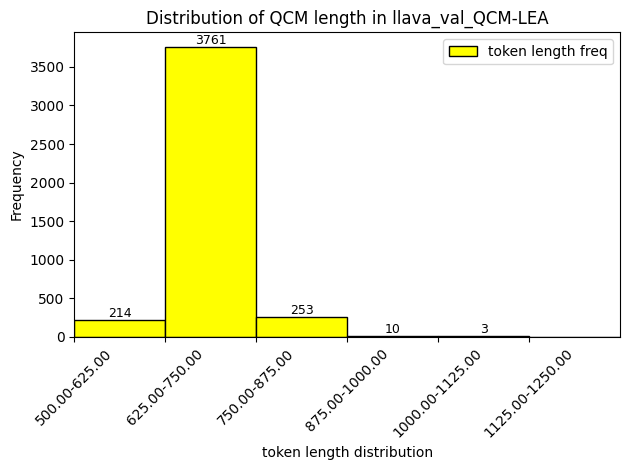

In [16]:
bin_start = 500
bin_end = 1250
bin_width = 125

bins = np.arange(bin_start, bin_end + bin_width, bin_width)
hist, bin_edges = np.histogram(val_sqa_qcm_len, bins=bins)
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='yellow')
plt.xlabel('token length distribution')
plt.ylabel('Frequency')
plt.title('Distribution of QCM length in llava_val_QCM-LEA')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['token length freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

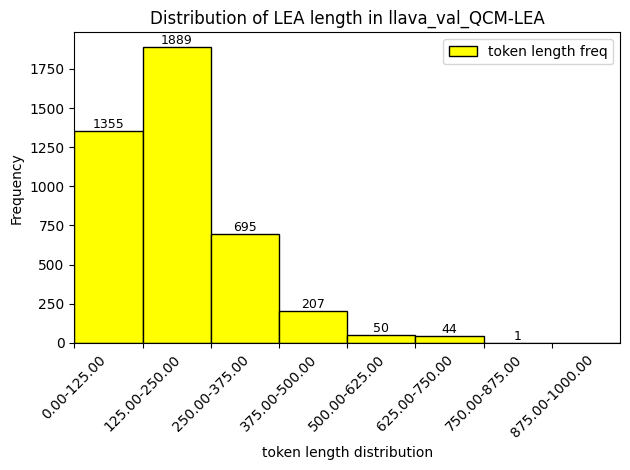

In [17]:
bin_start = 0
bin_end = 1000
bin_width = 125

bins = np.arange(bin_start, bin_end + bin_width, bin_width)
hist, bin_edges = np.histogram(val_sqa_lea_len, bins=bins)
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='yellow')
plt.xlabel('token length distribution')
plt.ylabel('Frequency')
plt.title('Distribution of LEA length in llava_val_QCM-LEA')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['token length freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()